## Hyperparameter tuning: LSTM

### Imports and Data Loading

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
import pickle

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/soonglee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
batch_size = 50
batch_size_train = 50
max_len = 28

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Import the preprocessed data

In [6]:
df_word_list = pd.read_csv('tweets_5000/vocab/word_list.csv')

In [7]:
word_list = df_word_list.iloc[:,0].to_list()

In [8]:
vocab_count = Counter(word_list)

In [9]:
vocab = sorted(vocab_count,key=vocab_count.get,reverse=True)[:5000]

In [10]:
count_words = sorted(vocab_count.values(), reverse=True)
len(count_words)

12495

In [13]:
vocab_all = sorted(vocab_count,key=vocab_count.get,reverse=True)

In [14]:
vocab_dict = {w:i+1 for i,w in enumerate(vocab)}

In [15]:
df_x_train_padded = pd.read_csv('tweets_5000/train/x_train_padded.csv')
df_x_valid_padded = pd.read_csv('tweets_5000/valid/x_valid_padded.csv')
df_X_test = pd.read_csv('tweets_5000/test/X_test.csv')
df_y_test = pd.read_csv('tweets_5000/test/y_test.csv')
df_y_train = pd.read_csv('tweets_5000/train/y_train.csv')
df_y_valid = pd.read_csv('tweets_5000/valid/y_valid.csv')

In [16]:
# convert dataframe  to numpy array
x_train_padded = df_x_train_padded.to_numpy()
x_valid_padded = df_x_valid_padded.to_numpy()
X_test = df_X_test.to_numpy().squeeze()
y_test = df_y_test.to_numpy().squeeze()
y_train = df_y_train.to_numpy().squeeze()
y_valid = df_y_valid.to_numpy().squeeze()

### Create final dataset for training

In [17]:
x_train_padded = np.array(x_train_padded)
x_valid_padded = np.array(x_valid_padded)

In [18]:
# Create tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_padded), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_valid_padded), torch.from_numpy(y_valid))

In [19]:
# Set up dataloader with shuffle on
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, drop_last=True)

In [20]:
# Display tweet and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([50, 28])
Labels batch shape: torch.Size([50])


In [21]:
tweet_0 = train_features[0].squeeze()
label_0 = train_labels[0]
print(f"Tweet: {tweet_0}\nLabel: {label_0}")

Tweet: tensor([  13, 1515,  355,  641,   13,    1,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])
Label: 1


### Define LSTM model

In [22]:
class TweetLSTM(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout, num_layers) :
        super().__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # The embedding layer takes the vocab size and the embeddings size as input
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # The LSTM layer takes in the the embedding size and the hidden vector size.
        #self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim,
                    num_layers=num_layers, batch_first=True)

        # Use dropout before the final layer to improve with regularization
        self.dropout = nn.Dropout(dropout)

        # The fully-connected layer takes in the hidden dim of the LSTM and
        #  outputs a 2x1 vector of the class scores.
        self.fc = nn.Linear(hidden_dim, 2)

    def forward(self, x, hidden):
        """
        The forward method takes in the input and the previous hidden state 
        """

        # The input is transformed to embeddings by passing it to the embedding layer
        embs = self.embedding(x)

        # The embedded inputs are fed to the LSTM alongside the previous hidden state
        out, hidden = self.lstm(embs, hidden)

        # Dropout is applied to the output and fed to the FC layer
        out = self.dropout(out)
        out = self.fc(out)

        # We extract the scores for the final hidden state since it is the one that matters.
        out = out[:, -1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim), 
                torch.zeros(self.num_layers, batch_size, self.hidden_dim))

### Initialize TweetLSTM class 

In [23]:
vocab_size = len(vocab) + 1  # vocabulary size = maximum integer index + 1
embedding_dim = 64
hidden_dim = 64
dropout = 0.2
num_layers = 1

#model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)
model = TweetLSTM(vocab_size, embedding_dim, hidden_dim, dropout, num_layers)

#moving to gpu
model.to(device)
print(model)

TweetLSTM(
  (embedding): Embedding(5001, 64, padding_idx=0)
  (lstm): LSTM(64, 64, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)


In [24]:
# loss and optimization functions
lr = 3e-4
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(out,label):
    _, pred = torch.max(out, 1)
    return torch.sum(pred == label)

## Hyperparameter tuning

number of epochs will be fixed at 12  
parameters to tune:  
    'learning_rate': [0.0003, 0.001, 0.01],  
    'hidden_size': [64, 128, 256],  
    'num_layers': [1, 2, 3]

In [25]:
#model = TweetLSTM(vocab_size, embedding_dim, hidden_dim, dropout, num_layers)

In [26]:
hidden_dim = [32, 64, 128]
vocab_size = len(vocab) + 1
embedding_dim = 64
num_layers = [1, 2, 3]

In [27]:
param_grid = []
for hd in hidden_dim:
    for nl in num_layers:
        param_grid.append([vocab_size, embedding_dim, hd, dropout, nl])

In [28]:
# (vocab_size, embedding_dim, hidden_dim, dropout, num_layers)
param_grid

[[5001, 64, 32, 0.2, 1],
 [5001, 64, 32, 0.2, 2],
 [5001, 64, 32, 0.2, 3],
 [5001, 64, 64, 0.2, 1],
 [5001, 64, 64, 0.2, 2],
 [5001, 64, 64, 0.2, 3],
 [5001, 64, 128, 0.2, 1],
 [5001, 64, 128, 0.2, 2],
 [5001, 64, 128, 0.2, 3]]

## Hyperparameter tuning function with preds and labels collection

### Collect the last epoch results only

In [29]:
# This function runs grids of parameters of hidden_size and num_layers.
def hyperparam_tuning(param_grid, epochs, learning_rate):
    '''
    input: param_grid, epochs, learning_rate
        param_grid: This is a collection of lists of parameters; (vocab_size, embedding_dim, hidden_dim, dropout, num_layers)
        epochs: number of epochs to run
    output: param_loss_acc, param_preds_labels
        param_loss_acc: 
    '''
    param_loss_acc = []
    param_preds_labels = []
    for param in param_grid:
        model = TweetLSTM(*param)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        clip = 5
        #epochs = 5
        valid_loss_min = np.inf
        # train for some number of epochs

        for epoch in range(epochs):
            epoch_preds = []
            epoch_labels = []
            train_losses = []
            train_acc = 0.0
            model.train()
            # initialize hidden state
            h = model.init_hidden(batch_size)
            for inputs, labels in train_dataloader:
               
                inputs, labels = inputs.to(device), labels.to(device)  
                # Get a new copy of initialized h, leaving the original h unchanged.
                h = tuple([x.data for x in h])
               
                model.zero_grad()
                output, h = model(inputs, h)
                # calculate the loss and perform backpropagation
                loss = criterion(output, labels)
                loss.backward()
                train_losses.append(loss.item())
                # calculating accuracy
                accuracy = acc(output,labels)
                train_acc += accuracy
                # clip helps prevent the exploding gradient problem in LSTM.
                nn.utils.clip_grad_norm_(model.parameters(), clip)
                optimizer.step()
        
            # Evaluate the model with x_valid data set
            val_h = model.init_hidden(batch_size)
            val_losses = []
            val_acc = 0.0
            model.eval()
            for inputs, labels in valid_dataloader:
                    val_h = tuple([each.data for each in val_h])
                    inputs, labels = inputs.to(device), labels.to(device)
                    output, val_h = model(inputs, val_h)
                    _, preds = torch.max(output, 1)  # will give 0 or 1 depending on output
                    val_loss = criterion(output, labels)
                    val_losses.append(val_loss.item())           
                    accuracy = acc(output,labels)
                    val_acc += accuracy
                    # change tensor to number
                    preds = [x.item() for x in preds]
                    labels = [x.item() for x in labels]
                    epoch_preds.extend(preds)
                    epoch_labels.extend(labels)                
                   
            epoch_train_loss = np.mean(train_losses)
            epoch_val_loss = np.mean(val_losses)
            epoch_train_acc = train_acc/len(train_dataloader.dataset)
            epoch_val_acc = val_acc/len(valid_dataloader.dataset)
    
            print(f'Parameters {param} Learning rate {learning_rate}')
            print(f'Epoch {epoch+1}')
            print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
            print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
            print(30 * '==')
        
        param_loss_acc.append([param, (epoch_train_loss.item(), epoch_val_loss.item(), 
                                       epoch_train_acc.item(), epoch_val_acc.item())])
        param_preds_labels.append([param, epoch_preds, epoch_labels])

    return param_loss_acc, param_preds_labels

In [30]:
param_loss_acc = hyperparam_tuning(param_grid, 12, 0.001)

Parameters [5001, 64, 32, 0.2, 1] Learning rate 0.001
Epoch 1
train_loss : 0.6947013105337436 val_loss : 0.6865545143099392
train_accuracy : 49.98080825805664 val_accuracy : 51.007484436035156
Parameters [5001, 64, 32, 0.2, 1] Learning rate 0.001
Epoch 2
train_loss : 0.6350730072993499 val_loss : 0.6170112560777103
train_accuracy : 65.29750061035156 val_accuracy : 66.60910034179688
Parameters [5001, 64, 32, 0.2, 1] Learning rate 0.001
Epoch 3
train_loss : 0.579495442028229 val_loss : 0.5687133976641823
train_accuracy : 70.71016693115234 val_accuracy : 69.71790313720703
Parameters [5001, 64, 32, 0.2, 1] Learning rate 0.001
Epoch 4
train_loss : 0.4852122183029468 val_loss : 0.55741046193768
train_accuracy : 77.50479888916016 val_accuracy : 72.48129272460938
Parameters [5001, 64, 32, 0.2, 1] Learning rate 0.001
Epoch 5
train_loss : 0.41207211980452907 val_loss : 0.5356141302515479
train_accuracy : 82.39923095703125 val_accuracy : 74.26597595214844
Parameters [5001, 64, 32, 0.2, 1] Learnin

In [493]:
# Run grid parameters with additional grid of learning rates. Loss/accuracy data and pred/label data are saved separately.
lr_nums = [0.0003, 0.001, 0.01]
epoch = 12
param_loss_acc_all = []
param_pred_label_all = []
for learning_rate in lr_nums:
    param_loss_acc, param_preds_labels = hyperparam_tuning(param_grid, epoch, learning_rate)
    param_loss_acc_all.append([learning_rate, param_loss_acc])
    param_pred_label_all.append([learning_rate, param_preds_labels])

Parameters [12496, 64, 32, 0.2, 1] Learning rate 0.0003
Epoch 1
train_loss : 0.6934498072816775 val_loss : 0.6941720317391789
train_accuracy : 49.84645080566406 val_accuracy : 46.4018440246582
Parameters [12496, 64, 32, 0.2, 1] Learning rate 0.0003
Epoch 2
train_loss : 0.6932066186116292 val_loss : 0.6935271673342761
train_accuracy : 50.076778411865234 val_accuracy : 46.51698303222656
Parameters [12496, 64, 32, 0.2, 1] Learning rate 0.0003
Epoch 3
train_loss : 0.6930053721253688 val_loss : 0.6919863188967985
train_accuracy : 50.19194030761719 val_accuracy : 52.61945724487305
Parameters [12496, 64, 32, 0.2, 1] Learning rate 0.0003
Epoch 4
train_loss : 0.6628948169258925 val_loss : 0.6361199301831862
train_accuracy : 63.109405517578125 val_accuracy : 64.53656005859375
Parameters [12496, 64, 32, 0.2, 1] Learning rate 0.0003
Epoch 5
train_loss : 0.6264371035190729 val_loss : 0.6171742712750155
train_accuracy : 66.21881103515625 val_accuracy : 66.66667175292969
Parameters [12496, 64, 32, 0.

In [494]:
# save the result in a pickle file. Since this is a long run, we would like to save it for analysis.
df_hyperparams_tuning = pd.DataFrame(param_loss_acc_all)
df_hyperparams_tuning.to_pickle('data/lstm/hyper_tuning_loss_acc.pkl')

In [495]:
df_hyperparams_tuning = pd.DataFrame(param_pred_label_all)
df_hyperparams_tuning.to_pickle('data/lstm/hyper_tuning_preds_labels.pkl')

### Plotting of hyperparameter tuning results

In [496]:
with open('data/lstm/hyper_tuning_loss_acc.pkl', 'rb') as f:
    df_hyper_tuning_loss_acc = pickle.load(f)

In [497]:
tuning_results = df_hyper_tuning_loss_acc.values.tolist() 

In [511]:
hyper_dict = {}
for x in tuning_results:
    learning_rate = x[0]
    # x[1] is [hyperparams, results]
    for y in x[1]:
        hypers = []
        hyperparams = y[0]
        hidden_dim = hyperparams[2]
        num_layers = hyperparams[4]
        # y[1] is the results, and y[1][3] is the validation accuracy
        results_num = y[1][3]
        #results_num = results_tensor.item()
        results = round(results_num, 3)
        hypers.append((learning_rate, hidden_dim, num_layers))
        hyper_dict[hypers[0]] = results

In [529]:
# collect the rows with lr = 0.0003, 0.001, and 0.01
lr1 = "lr=0.0003"
lr2 = "lr=0.001"
lr3 = "lr=0.01"
# hs for "hidden size"
hs1 = "hidden_dim=32"
hs2 = "hidden_dim=64"
hs3 = "hidden_dim=128"
hyper_data = {}
val_accuracy = [[] for _ in range(9)]
for k, v in hyper_dict.items():
    # k[0]:learning rate, k[1]: hidden dim
    if k[0] == 0.0003:   
        if k[1] == 32:
            # val_accuracy[0] is an accuracy for lr1 and hs1
            val_accuracy[0].append(v)
        elif k[1] == 64:
            # val_accuracy[1] is an accuracy for lr1 and hs2
            val_accuracy[1].append(v)
        else:
            # val_accuracy[2] is an accuracy for lr1 and hs3
            val_accuracy[2].append(v)
    elif k[0] == 0.001:   
        if k[1] == 32:
            val_accuracy[3].append(v)
        elif k[1] == 64:
            val_accuracy[4].append(v)
        else:
            val_accuracy[5].append(v)
    else:   
        if k[1] == 32:
            val_accuracy[6].append(v)
        elif k[1] == 64:
            val_accuracy[7].append(v)
        else:
            val_accuracy[8].append(v)
    hyper_data.update({lr1 : {hs1 : val_accuracy[0], hs2 : val_accuracy[1], hs3 : val_accuracy[2]},
                      lr2 : {hs1 : val_accuracy[3], hs2 : val_accuracy[4], hs3 : val_accuracy[5]},
                      lr3 : {hs1 : val_accuracy[6], hs2 : val_accuracy[7], hs3 : val_accuracy[8]}})

In [530]:
hyper_data

{'lr=0.0003': {'hidden_dim=32': [0.733, 0.734, 0.759],
  'hidden_dim=64': [0.736, 0.733, 0.765],
  'hidden_dim=128': [0.762, 0.757, 0.75]},
 'lr=0.001': {'hidden_dim=32': [0.764, 0.766, 0.752],
  'hidden_dim=64': [0.758, 0.756, 0.759],
  'hidden_dim=128': [0.762, 0.766, 0.776]},
 'lr=0.01': {'hidden_dim=32': [0.767, 0.754, 0.754],
  'hidden_dim=64': [0.748, 0.748, 0.757],
  'hidden_dim=128': [0.766, 0.774, 0.472]}}

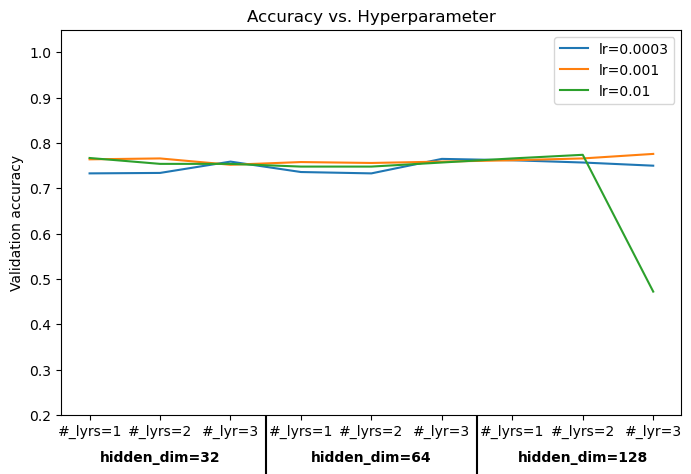

In [531]:
## Convert to the form that is easy to plot - First index by name and then by Subject
df_hyper = pd.DataFrame(hyper_data).drop(['lr=0.001', 'lr=0.01'], axis=1).explode('lr=0.0003')
df_hyper['lr=0.001'] = pd.DataFrame(hyper_data).drop(['lr=0.0003', 'lr=0.01'], axis=1).explode('lr=0.001')
df_hyper['lr=0.01'] = pd.DataFrame(hyper_data).drop(['lr=0.0003', 'lr=0.001'], axis=1).explode('lr=0.01')
df_hyper['num_layers'] = ['#_lyrs=1', '#_lyrs=2', '#_lyr=3']*3
df_hyper.set_index('num_layers', append=True, inplace=True)

## Figure of size you want and plot... 
fig, ax = plt.subplots(figsize=(8,5))
df_hyper.plot(xlabel='', ax=ax)
ax.set_ylim(0.2, 1.05)
ax.set_ylabel('Validation accuracy')
ax.set_title("Accuracy vs. Hyperparameter")

## Set the x-tick labels to the subjects (first level). As lineplot gives extra space at start and end, add blanks
myticklabels= df_hyper.index.get_level_values(level=1).tolist()
myticklabels.insert(0,'') 
myticklabels.append('')

## First level labels as per subject 
ax.set_xticklabels(myticklabels, rotation=0)

## Draw vertical lines (I am not including the lines at the ends)
pos=[]
pos.append(-0.5)
for i in range(len(df_hyper.index.unique(level=0))):
    pos.append((i+1)*len(df_hyper.index.unique(level='num_layers'))-0.5)
ax.vlines(pos[1:-1], 0, -0.4, color='black', lw=1.5, clip_on=False, transform=ax.get_xaxis_transform())

## Draw second level axes ticklables
for ps0, ps1, lbl in zip(pos[:-1], pos[1:], df_hyper.index.unique(level=0)):
    ax.text((ps0 + ps1) / 2, -0.12, lbl, ha='center', clip_on=False, transform=ax.get_xaxis_transform(), weight = 'bold', size=10)


### Precision, Recall, and F1 Score

In [503]:
with open('data/lstm/hyper_tuning_preds_labels.pkl', 'rb') as f:
    df_hyper_tuning_preds_labels = pickle.load(f)

In [504]:
tuning_results_preds_labels = df_hyper_tuning_preds_labels.values.tolist() 

In [517]:
# calculate confusion matrix metrices
def calc_metrics(y_pred, y_true):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()    
    precision = round(tp / (tp + fp), 3)
    recall = round(tp / (tp + fn), 3)
    f1_score = round(2 * precision * recall / (precision + recall), 3)

    return precision, recall, f1_score

In [518]:
hyper_dict2 = {}
for pred_label in tuning_results_preds_labels:
    learning_rate = pred_label[0]
    # pred_label[1] is [hyerparams, results]
    hyper_results = pred_label[1]  # contains hyperparams, preds, and labels
    for hyper_result in hyper_results: 
        hypers = []
        hyperparams = hyper_result[0]
        hidden_dim = hyperparams[2]
        num_layers = hyperparams[4]
        hypers.append((learning_rate, hidden_dim, num_layers))
        # hyper_result[1]: predictions, and hyper_result[2]: labels
        preds = hyper_result[1]
        labels = hyper_result[2]
        # calculate precision, recall, and f1 score
        precision, recall, f1_score = calc_metrics(preds, labels)
        hyper_dict2[hypers[0]] = [precision, recall, f1_score]

In [534]:
def hyper_data_assign(metric_num, hyper_dict):
    '''
    collect the rows with lr = 0.0003, 0.001, and 0.01
    input: metric_num and hyper_dict
        metric_num: 0:precision, 1:recall, 2:f1_score
        hyper_dict: a dictionary arranged with hyperparameters and results (created above)
    '''

    lr1 = "lr=0.0003"
    lr2 = "lr=0.001"
    lr3 = "lr=0.01"
    hs1 = "hidden_dim=32"
    hs2 = "hidden_dim=64"
    hs3 = "hidden_dim=128"
    hyper_data = {}
    metric_values = [[] for _ in range(9)]
    for k, metrics in hyper_dict.items():
        v = metrics[metric_num]
        if k[0] == 0.0003:   
            if k[1] == 32:
                metric_values[0].append(v.item())
            elif k[1] == 64:
                metric_values[1].append(v.item())
            else:
                metric_values[2].append(v.item())
        elif k[0] == 0.001:   
            if k[1] == 32:
                metric_values[3].append(v.item())
            elif k[1] == 64:
                metric_values[4].append(v.item())
            else:
                metric_values[5].append(v.item())
        else:   
            if k[1] == 32:
                metric_values[6].append(v.item())
            elif k[1] == 64:
                metric_values[7].append(v.item())
            else:
                metric_values[8].append(v.item())
        hyper_data.update({lr1 : {hs1 : metric_values[0], hs2 : metric_values[1], hs3 : metric_values[2]},
                          lr2 : {hs1 : metric_values[3], hs2 : metric_values[4], hs3 : metric_values[5]},
                          lr3 : {hs1 : metric_values[6], hs2 : metric_values[7], hs3 : metric_values[8]}})
        
    return hyper_data

In [549]:
def plot_metrics_vs_hyperparams(hyper_data, metric_num):
    if metric_num == 0:
        metric_name = 'Precision'
    elif metric_num == 1:
        metric_name = 'Recall'
    else:
        metric_name = 'F1_score'
    ## Convert to the form that is easy to plot - First index by name and then by Subject
    df_hyper = pd.DataFrame(hyper_data).drop(['lr=0.001', 'lr=0.01'], axis=1).explode('lr=0.0003')
    df_hyper['lr=0.001'] = pd.DataFrame(hyper_data).drop(['lr=0.0003', 'lr=0.01'], axis=1).explode('lr=0.001')
    df_hyper['lr=0.01'] = pd.DataFrame(hyper_data).drop(['lr=0.0003', 'lr=0.001'], axis=1).explode('lr=0.01')
    df_hyper['num_layers'] = ['#_lyrs=1', '#_lyrs=2', '#_lyr=3']*3
    df_hyper.set_index('num_layers', append=True, inplace=True)
    
    ## Figure of size you want and plot... 
    fig, ax = plt.subplots(figsize=(8,5))
    df_hyper.plot(xlabel='', ax=ax)
    ax.set_ylim(0.2, 1.05)
    ax.set_ylabel(f'{metric_name}')
    ax.set_title(f"{metric_name} vs. Hyperparameter")
    
    ## Set the x-tick labels to the subjects (first level). As lineplot gives extra space at start and end, add blanks
    myticklabels= df_hyper.index.get_level_values(level=1).tolist()
    myticklabels.insert(0,'') 
    myticklabels.append('')
    
    ## First level labels as per subject 
    ax.set_xticklabels(myticklabels, rotation=0)
    
    ## Draw vertical lines (I am not including the lines at the ends)
    pos=[]
    pos.append(-0.5)
    for i in range(len(df_hyper.index.unique(level=0))):
        pos.append((i+1)*len(df_hyper.index.unique(level='num_layers'))-0.5)
    ax.vlines(pos[1:-1], 0, -0.4, color='black', lw=1.5, clip_on=False, transform=ax.get_xaxis_transform())
    
    ## Draw second level axes ticklables
    for ps0, ps1, lbl in zip(pos[:-1], pos[1:], df_hyper.index.unique(level=0)):
        ax.text((ps0 + ps1) / 2, -0.12, lbl, ha='center', clip_on=False, transform=ax.get_xaxis_transform(), weight = 'bold', size=10)

    return None

#### Precision

In [555]:
hyper_data0 = hyper_data_assign(0, hyper_dict2)

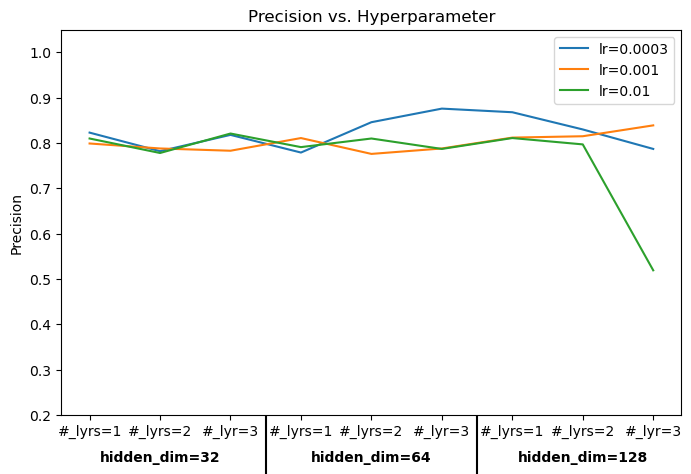

In [556]:
plot_metrics_vs_hyperparams(hyper_data0, 0)

#### Recall

In [557]:
hyper_data1 = hyper_data_assign(1, hyper_dict2)

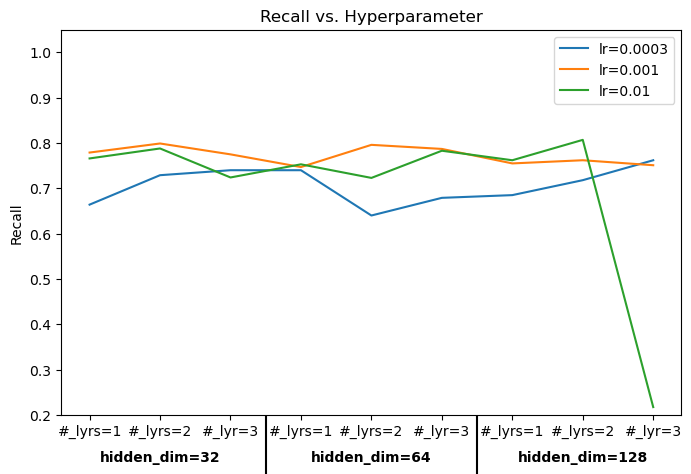

In [558]:
plot_metrics_vs_hyperparams(hyper_data1, 1)

#### F1 Score

In [559]:
hyper_data2 = hyper_data_assign(2, hyper_dict2)

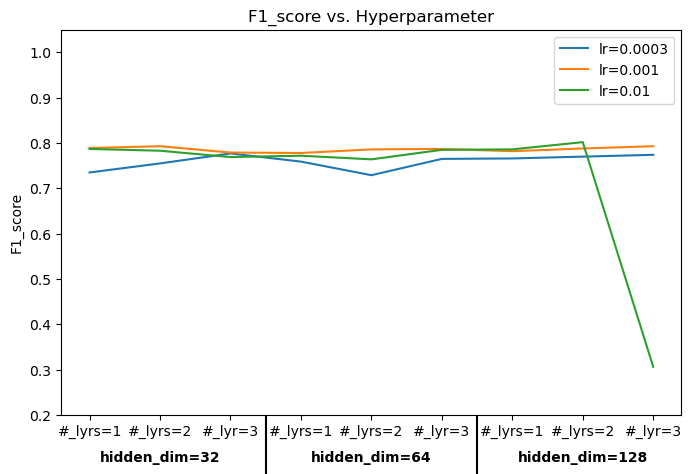

In [560]:
plot_metrics_vs_hyperparams(hyper_data2, 2)